<a href="https://colab.research.google.com/github/CodeCreator333/colab-projects/blob/main/backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Ethereum Backtesting Algorithmus - MODULAR VERSION
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime

# =======================
# PARAMETER DICTIONARY
# =======================
PARAMS = {
    'ticker': 'ETH-USD',
    'start_date': '2023-02-19',
    'end_date': '2025-10-16',
    'initial_capital': 10000,
    'sma_short': 20,
    'sma_long': 50,
    'stop_loss_pct': 2,
    'take_profit_pct': 5,
    'trading_fee_pct': 0.1
}

print(f"Lade {PARAMS['ticker']} Daten...")
eth_data = yf.download(PARAMS['ticker'], start=PARAMS['start_date'], end=PARAMS['end_date'], progress=False)
eth_data['SMA_20'] = eth_data['Close'].rolling(window=PARAMS['sma_short']).mean()
eth_data['SMA_50'] = eth_data['Close'].rolling(window=PARAMS['sma_long']).mean()
eth_data.dropna(inplace=True)

print(f"Daten geladen: {len(eth_data)} Tage")
print(f"Zeitraum: {eth_data.index[0].strftime('%Y-%m-%d')} bis {eth_data.index[-1].strftime('%Y-%m-%d')}\n")

# =======================
# BACKTESTING ENGINE
# =======================
in_position = False
entry_price = 0
entry_date = None
capital = PARAMS['initial_capital']
trades = []

for i in range(len(eth_data)):
    current_date = eth_data.index[i]
    current_price = float(eth_data['Close'].iloc[i])
    sma_20 = float(eth_data['SMA_20'].iloc[i])
    sma_50 = float(eth_data['SMA_50'].iloc[i])

    if not in_position:
        # Enhanced Entry Signal:
        # 1. Close > SMA(20) OR Close > SMA(50)
        # 2. SMA(20) > SMA(50) (trend filter)
        # 3. Close above both SMAs
        price_above_sma = (current_price > sma_20) or (current_price > sma_50)
        trend_up = sma_20 > sma_50
        price_above_both = (current_price > sma_20) and (current_price > sma_50)

        entry_condition = price_above_sma and trend_up and price_above_both

        if entry_condition:
            in_position = True
            entry_price = current_price
            entry_date = current_date

    else:
        # Exit conditions
        profit_pct = ((current_price - entry_price) / entry_price) * 100

        # Stop Loss
        if profit_pct <= -PARAMS['stop_loss_pct']:
            exit_price = current_price
            exit_reason = 'Stop Loss'
            profit_usd = (exit_price - entry_price) * (capital / entry_price) * (1 - PARAMS['trading_fee_pct']/100)
            trades.append({
                'Entry Date': entry_date,
                'Entry Price': entry_price,
                'Exit Date': current_date,
                'Exit Price': exit_price,
                'Exit Reason': exit_reason,
                'Profit USD': profit_usd,
                'Profit %': profit_pct
            })
            capital += profit_usd
            in_position = False

        # Take Profit
        elif profit_pct >= PARAMS['take_profit_pct']:
            exit_price = current_price
            exit_reason = 'Take Profit'
            profit_usd = (exit_price - entry_price) * (capital / entry_price) * (1 - PARAMS['trading_fee_pct']/100)
            trades.append({
                'Entry Date': entry_date,
                'Entry Price': entry_price,
                'Exit Date': current_date,
                'Exit Price': exit_price,
                'Exit Reason': exit_reason,
                'Profit USD': profit_usd,
                'Profit %': profit_pct
            })
            capital += profit_usd
            in_position = False

# FINAL EXIT: Close any open position at last price
if in_position:
    exit_price = float(eth_data['Close'].iloc[-1])
    exit_date = eth_data.index[-1]
    profit_pct = ((exit_price - entry_price) / entry_price) * 100
    profit_usd = (exit_price - entry_price) * (capital / entry_price) * (1 - PARAMS['trading_fee_pct']/100)
    trades.append({
        'Entry Date': entry_date,
        'Entry Price': entry_price,
        'Exit Date': exit_date,
        'Exit Price': exit_price,
        'Exit Reason': 'Final Exit',
        'Profit USD': profit_usd,
        'Profit %': profit_pct
    })
    capital += profit_usd
    in_position = False

# =======================
# RESULTS
# =======================
df_trades = pd.DataFrame(trades)

print("=== BACKTESTING ERGEBNISSE ===")
print(f"Startkapital: ${PARAMS['initial_capital']:.2f}")
print(f"Trading Fee: {PARAMS['trading_fee_pct']}%")
print(f"Stop Loss: {PARAMS['stop_loss_pct']}%")
print(f"Take Profit: {PARAMS['take_profit_pct']}%\n")

if len(trades) > 0:
    winning_trades = df_trades[df_trades['Profit USD'] > 0]
    losing_trades = df_trades[df_trades['Profit USD'] < 0]

    print(f"Anzahl Trades: {len(trades)}")
    print(f"Gewinn-Trades: {len(winning_trades)}")
    print(f"Verlust-Trades: {len(losing_trades)}")
    print(f"Win Rate: {len(winning_trades)/len(trades)*100:.2f}%\n")

    total_profit = df_trades['Profit USD'].sum()
    print(f"Gesamtprofit: ${total_profit:.2f}")
    print(f"Durchschnittlicher Profit pro Trade: ${total_profit/len(trades):.2f}")

    if losing_trades['Profit USD'].sum() != 0:
        profit_factor = abs(winning_trades['Profit USD'].sum() / losing_trades['Profit USD'].sum())
        print(f"Profit Factor: {profit_factor:.2f}\n")

    print("--- TRADE DATAFRAME ---")
    print(df_trades.to_string(index=False))
else:
    print("Keine Trades ausgeführt!")

print("\nBacktesting abgeschlossen!")

Lade ETH-USD Daten...
Daten geladen: 921 Tage
Zeitraum: 2023-04-09 bis 2025-10-15



/tmp/ipython-input-1886617512.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth_data = yf.download(PARAMS['ticker'], start=PARAMS['start_date'], end=PARAMS['end_date'], progress=False)
/tmp/ipython-input-1886617512.py:42: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(eth_data['Close'].iloc[i])


=== BACKTESTING ERGEBNISSE ===
Startkapital: $10000.00
Trading Fee: 0.1%
Stop Loss: 2%
Take Profit: 5%

Anzahl Trades: 74
Gewinn-Trades: 34
Verlust-Trades: 40
Win Rate: 45.95%

Gesamtprofit: $8744.98
Durchschnittlicher Profit pro Trade: $118.18
Profit Factor: 1.37

--- TRADE DATAFRAME ---
Entry Date  Entry Price  Exit Date  Exit Price Exit Reason   Profit USD  Profit %
2023-04-09  1859.387817 2023-04-13 2012.634644 Take Profit   823.354751  8.241789
2023-04-14  2101.635498 2023-04-19 1936.403442   Stop Loss  -850.088796 -7.862070
2023-04-20  1943.097656 2023-04-21 1849.999878   Stop Loss  -477.361707 -4.791204
2023-05-05  1995.060913 2023-05-06 1900.221802   Stop Loss  -450.954921 -4.753695
2023-07-04  1936.633545 2023-07-06 1848.636475   Stop Loss  -410.574894 -4.543816
2023-07-13  2006.511475 2023-07-14 1939.347046   Stop Loss  -288.731418 -3.347323
2023-07-15  1931.466553 2023-07-19 1889.007935   Stop Loss  -183.275307 -2.198258
2023-10-27  1780.045288 2023-11-05 1894.157715 Take Pr


=== BUY-AND-HOLD STRATEGIE ===
Startkapital: $10000.00
Endkapital: $21445.01
Profit: $11445.01
Return: 114.45%

=== VERGLEICH ===
Backtest-Strategie Endkapital: $18744.98
Buy-and-Hold Endkapital: $21445.01
Unterschied: $-2700.03
Backtest uebertrifft B&H um: -12.59%


/tmp/ipython-input-876580011.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  first_price = float(eth_data['Close'].iloc[0])
/tmp/ipython-input-876580011.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(eth_data['Close'].iloc[-1])
/tmp/ipython-input-876580011.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10823.354751034083' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  backtest_equity.loc[date] = current_capital


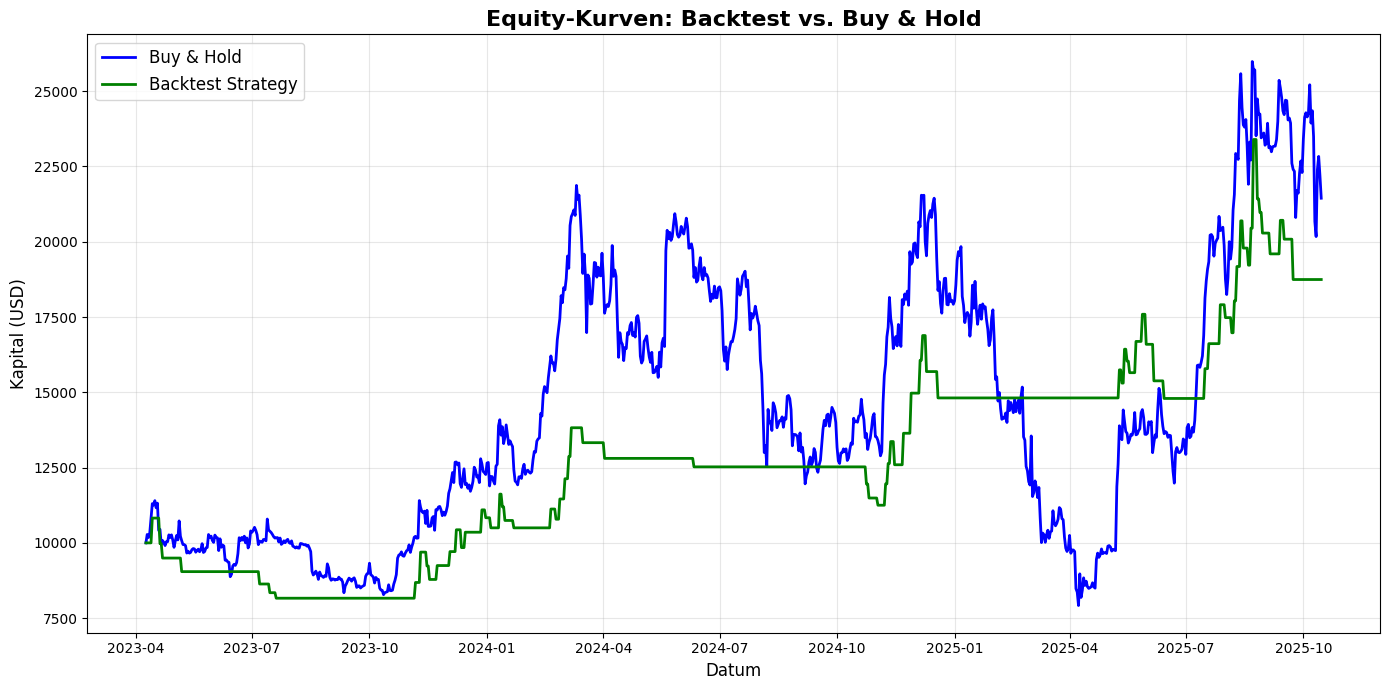


Visualisierung abgeschlossen!


In [27]:
# Buy-and-Hold Vergleich und Equity-Kurve Visualisierung mit Tagesdaten
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Berechne finale Kapitalwerte
if trades:
    final_capital = PARAMS['initial_capital'] + df_trades['Profit USD'].sum()
else:
    final_capital = PARAMS['initial_capital']

# Buy-and-Hold Strategie
first_price = float(eth_data['Close'].iloc[0])
last_price = float(eth_data['Close'].iloc[-1])
amount_bought = PARAMS['initial_capital'] / first_price
buy_hold_final = amount_bought * last_price
buy_hold_profit = buy_hold_final - PARAMS['initial_capital']
buy_hold_return = (buy_hold_profit / PARAMS['initial_capital']) * 100

print("\n=== BUY-AND-HOLD STRATEGIE ===")
print(f"Startkapital: ${PARAMS['initial_capital']:.2f}")
print(f"Endkapital: ${buy_hold_final:.2f}")
print(f"Profit: ${buy_hold_profit:.2f}")
print(f"Return: {buy_hold_return:.2f}%")

print("\n=== VERGLEICH ===")
print(f"Backtest-Strategie Endkapital: ${final_capital:.2f}")
print(f"Buy-and-Hold Endkapital: ${buy_hold_final:.2f}")
print(f"Unterschied: ${final_capital - buy_hold_final:.2f}")
if buy_hold_final > 0:
    outperformance = ((final_capital - buy_hold_final) / buy_hold_final) * 100
    print(f"Backtest uebertrifft B&H um: {outperformance:.2f}%")

# ==========================================
# TÄGLICHE EQUITY-KURVEN BERECHNUNG
# ==========================================

# 1. Buy-and-Hold Equity-Kurve für jeden Tag
buy_hold_equity = (eth_data['Close'] / first_price) * PARAMS['initial_capital']

# 2. Backtest Equity-Kurve für jeden Tag
backtest_equity = pd.Series(PARAMS['initial_capital'], index=eth_data.index)

if trades:
    df_trades_copy = df_trades.copy()
    df_trades_copy['Entry Date'] = pd.to_datetime(df_trades_copy['Entry Date'])
    df_trades_copy['Exit Date'] = pd.to_datetime(df_trades_copy['Exit Date'])

    current_capital = PARAMS['initial_capital']

    for date in eth_data.index:
        # Prüfe ob ein Trade vor diesem Datum beendet wurde
        completed_trades = df_trades_copy[df_trades_copy['Exit Date'] < date]
        if len(completed_trades) > 0:
            current_capital = PARAMS['initial_capital'] + completed_trades['Profit USD'].sum()

        backtest_equity.loc[date] = current_capital

# ==========================================
# VISUALISIERUNG MIT DATUM AUF X-ACHSE
# ==========================================

plt.figure(figsize=(14, 7))
plt.plot(eth_data.index, buy_hold_equity, label='Buy & Hold', linewidth=2, color='blue')
plt.plot(eth_data.index, backtest_equity, label='Backtest Strategy', linewidth=2, color='green')

plt.title('Equity-Kurven: Backtest vs. Buy & Hold', fontsize=16, fontweight='bold')
plt.xlabel('Datum', fontsize=12)
plt.ylabel('Kapital (USD)', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nVisualisierung abgeschlossen!")